<a href="https://colab.research.google.com/github/Saadi128/EDA-PROJECT-REPORT/blob/main/Computer_Vision_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %% [markdown]
# CIFAR-10: Baseline vs Improved CNN
# Goal: Push test accuracy above 80% using simple CNNs (no transfer learning).
# This notebook:
# Loads & normalizes CIFAR-10 (+ optional augmentation)
# Trains a baseline CNN and records test accuracy
# Trains an improved CNN with BN/Dropout/L2, LR scheduler, early stopping, and checkpoints
# Plots training curves and reports confusion matrix + classification report

# Notes:
# Results vary by hardware and random seed.
# For best speed/accuracy, run on GPU (Colab: Runtime -> Change runtime type -> GPU).

# %% [markdown]
# Setup: Imports, seeds, and utility functions

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Reproducibility (still not 100% deterministic on GPU, but helps)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# %% [markdown]
# ## 1. Load & normalize CIFAR-10, make a validation split

# %%
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_classes = 10
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [4]:
# Normalize to [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Create a stratified validation split (10% of train)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

x_train.shape, x_val.shape, x_test.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
# %% [markdown]
# ## 2. (Optional) Data Augmentation for training
# Augmentation improves generalization. We'll keep it modest to avoid distorting tiny images too much.

# %%
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='reflect'
)

In [6]:
# No augmentation for val/test
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [7]:
# Build generators (Keras works fine with integer labels here)
batch_size = 128
train_gen = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True, seed=SEED)
val_gen   = val_datagen.flow(x_val,   y_val,   batch_size=batch_size, shuffle=False)
test_gen  = test_datagen.flow(x_test, y_test,  batch_size=batch_size, shuffle=False)

In [8]:
# %% [markdown]
# ## 3. Baseline CNN
# A small, plain CNN to establish a baseline test accuracy.

# %%
def build_baseline_cnn(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline = build_baseline_cnn()
baseline.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
baseline.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# %% [markdown]
# ### Train baseline
# We'll train for a modest number of epochs to get a quick baseline.

# %%
epochs_baseline = 20
history_baseline = baseline.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_baseline,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.2439 - loss: 2.0181 - val_accuracy: 0.4666 - val_loss: 1.4783
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.4179 - loss: 1.6029 - val_accuracy: 0.5200 - val_loss: 1.3267
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - accuracy: 0.4577 - loss: 1.4934 - val_accuracy: 0.5704 - val_loss: 1.1979
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.4817 - loss: 1.4415 - val_accuracy: 0.5800 - val_loss: 1.1759
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.4981 - loss: 1.3959 - val_accuracy: 0.6104 - val_loss: 1.0980
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.5141 - loss: 1.3506 - val_accuracy: 0.5868 - val_loss: 1.1301
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.5292 - loss: 1.3175 - val_accuracy: 0.6194 - val_loss: 1.0713
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.5364 - loss: 1.3087 - val_accura

In [10]:
# %% [markdown]
# ### Evaluate baseline on test set

# %%
test_loss_base, test_acc_base = baseline.evaluate(test_gen, verbose=0)
print(f"Baseline Test Accuracy: {test_acc_base:.4f}")

Baseline Test Accuracy: 0.6861


In [19]:
def build_improved_cnn(input_shape=(32,32,3), num_classes=10, weight_decay=1e-4, dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    x = conv_block(inputs, 32, weight_decay)
    x = conv_block(x,      32, weight_decay)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = conv_block(x, 64, weight_decay)
    x = conv_block(x, 64, weight_decay)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = conv_block(x, 128, weight_decay)
    x = conv_block(x, 128, weight_decay)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Make sure this line is at the same indentation as the ones above
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model


In [21]:
improved = build_improved_cnn()

# Try Adam or SGD+Momentum (either can reach >80%; Adam is simpler to tune)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# Alternative:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, nesterov=True)

improved.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
improved.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 306,602 (1.17 MB)

 Trainable params: 305,706 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

In [22]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint('best_improved.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [24]:
epochs_improved = 60
history_improved = improved.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs_improved,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8233 - loss: 0.6286
Epoch 1: val_accuracy did not improve from 0.84760
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8233 - loss: 0.6286 - val_accuracy: 0.8424 - val_loss: 0.5496 - learning_rate: 1.0000e-05
Epoch 2/60
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8180 - loss: 0.6249
Epoch 2: val_accuracy did not improve from 0.84760
352/352 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.8180 - loss: 0.6249 - val_accuracy: 0.8416 - val_loss: 0.5526 - learning_rate: 1.0000e-05
Epoch 3/60
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8196 - loss: 0.6315
Epoch 3: val_accuracy did not improve from 0.84760
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.8196 - loss: 0.6315 - val_accuracy: 0.8428 - val_loss: 0.5483 - learning_rate: 1.0000e-05
Epoch 4/60
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8240 - loss: 0.6149
Epoch 4: val_accuracy did not improve from 0.84760
352/352

In [25]:
# The EarlyStopping restored best weights already; but we can ensure checkpoint usage if desired:
if os.path.exists('best_improved.keras'):
    improved.load_weights('best_improved.keras')

test_loss_imp, test_acc_imp = improved.evaluate(test_gen, verbose=0)
print(f"Improved Test Accuracy: {test_acc_imp:.4f}")
print(f"Baseline vs Improved: {test_acc_base:.4f}  ->  {test_acc_imp:.4f}")

Improved Test Accuracy: 0.8339
Baseline vs Improved: 0.6861  ->  0.8339


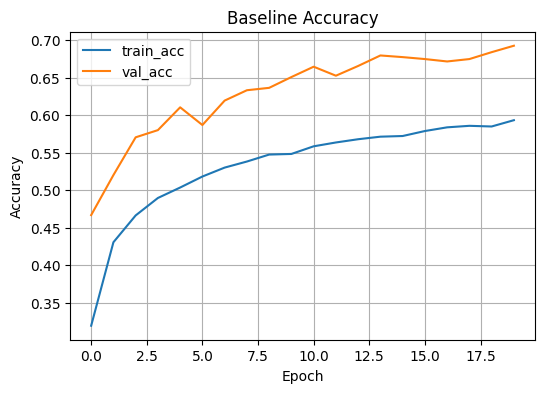

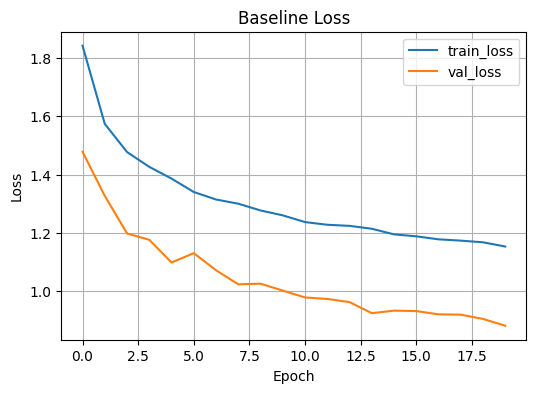

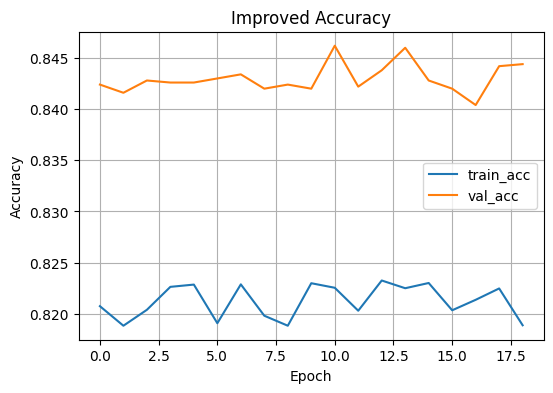

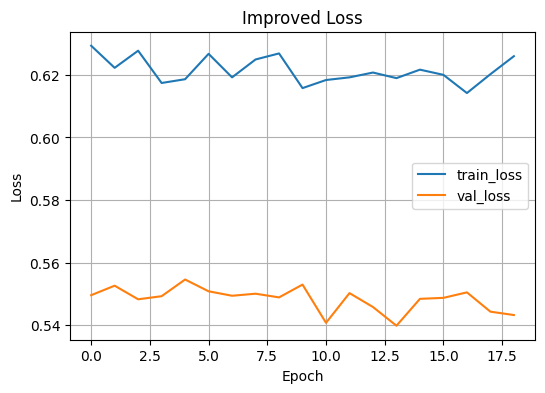

In [26]:
def plot_history(hist, title_prefix=""):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(f'{title_prefix} Accuracy')
    plt.legend(); plt.grid(True); plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{title_prefix} Loss')
    plt.legend(); plt.grid(True); plt.show()

plot_history(history_baseline, "Baseline")
plot_history(history_improved, "Improved")


In [27]:
# Predict class indices
y_prob = improved.predict(test_gen, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = y_test.flatten()


In [28]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[843  19  14   7   9   1   7   7  46  47]
 [  5 945   0   0   0   0   1   0   3  46]
 [ 51   3 694  16  40  37 110  28   5  16]
 [ 13   9  29 591  41 105 135  36  18  23]
 [  7   1  31  10 803   5 101  37   4   1]
 [  6   2  11  93  39 734  48  52   7   8]
 [  5   1   8  13   6   2 957   3   2   3]
 [ 10   1   6   8  13  19  25 902   2  14]
 [ 26  19   0   1   1   1   5   0 921  26]
 [ 10  25   1   1   1   1   2   3   7 949]]


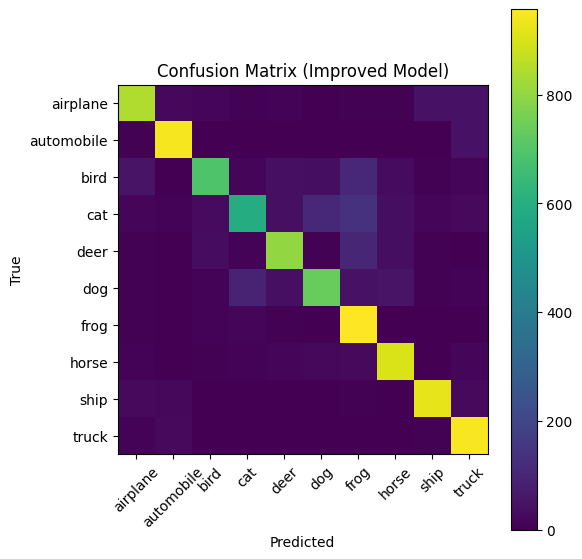

In [29]:
# Plot confusion matrix (small 10x10)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Improved Model)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

In [30]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

    airplane     0.8637    0.8430    0.8532      1000
  automobile     0.9220    0.9450    0.9333      1000
        bird     0.8741    0.6940    0.7737      1000
         cat     0.7986    0.5910    0.6793      1000
        deer     0.8426    0.8030    0.8223      1000
         dog     0.8110    0.7340    0.7706      1000
        frog     0.6880    0.9570    0.8005      1000
       horse     0.8446    0.9020    0.8723      1000
        ship     0.9074    0.9210    0.9141      1000
       truck     0.8376    0.9490    0.8898      1000

    accuracy                         0.8339     10000
   macro avg     0.8390    0.8339    0.8309     10000
weighted avg     0.8390    0.8339    0.8309     10000

